In [1]:
import numpy as np
import sympy as sp
# from sympy.abc import *
from typing import Iterable
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'].append('SimHei')

In [65]:

x = sp.symbols('x') # 符号化

X = [(x / 5).subs(x, i) for i in range(-5, 6)]
Y = [1 / (1 + x**2)**0.5 for x in X]
m = len(X) # 插值点的个数

def InnerProduct(f1: sp.core.Expr, f2: sp.core.Expr, X: Iterable):
    '''
    计算形如 sum(i,0,m) w[i]*f1[i]*f2[i]\n
    当然这里已经默认了多项式是不带权重的，故实际上是\n
    sum(i,0,m) f1[i]*f2[i]

    参数
    ----
    f1: sp.core.Expr
        第一个多项式
    f2: sp.core.Expr
        第二个多项式
    X: Iterable
        自变量数列
    '''
    return sum(f1.subs(x, x_value)*f2.subs(x, x_value) for x_value in X)

n = 4; # 需要拟合的次数n+1(如3次的时候对应4)
Poly = [0 for i in range(n)] # 初始化多项式
a =[0 for i in range(n - 1)] # 初始化系数矩阵a，注意a是从多项式P1开始的，因此比多项式项数少一
b =[0 for i in range(n - 2)] # 初始化系数矩阵b，注意是从多项式P2开始的，因此比多项式项数少二
Poly[0] = sp.Integer(1)
a[0] = InnerProduct(x * Poly[0], Poly[0], X)/(InnerProduct(Poly[0], Poly[0], X))
Poly[1] = (x - a[0]) * Poly[0]
for i in range(n - 2):
    a[i + 1] = InnerProduct(x * Poly[i + 1], Poly[i + 1], X)/(InnerProduct(Poly[i + 1], Poly[i + 1], X))
    b[i] = InnerProduct(Poly[i + 1], Poly[i + 1], X)/InnerProduct(Poly[i], Poly[i], X)
    Poly[i + 2] = (x - a[i + 1]) * Poly[i + 1] - b[i] * Poly[i]
PolyCoeff = [InnerProduct(1 / sp.sqrt(1 + x**2), Poly[i], X) / (InnerProduct(Poly[i], Poly[i], X)) for i in range(n)]
PolyFit = np.dot(np.array(PolyCoeff), np.array(Poly))
PolyFit

(x**2 - 2/5)*(-375*sqrt(26)/3718 - 250*sqrt(29)/4147 - 125/429 - 125*sqrt(34)/14586 + 250*sqrt(41)/5863 + 125*sqrt(2)/286) + 1/11 + sqrt(2)/11 + 10*sqrt(41)/451 + 5*sqrt(34)/187 + 10*sqrt(29)/319 + 5*sqrt(26)/143

In [66]:
def divided_difference(x, y):
    return (
        None
        if len(x) == 0
        else y[0]
        if len(x) == 1
        else (divided_difference(x[1:], y[1:]) - divided_difference(x[:-1], y[:-1]))
        / (x[-1] - x[0])
    )


class CubicSpline:
    def __init__(self, x, y, dS):
        """
        Parameters
        ----------
        x : array_like
            一维数组，表示插值节点
        y : array_like
            一维数组，表示插值节点处的函数值
        dS : array_like
            长度为2的数组, 表示两个边界点处的导数值
        """
        assert len(x) == len(y), "x 和 y 的长度不一致"
        self.x = x
        self.y = y
        self.h = h = np.diff(x)
        self.n = n = len(h)

        A = np.eye(n + 1) * 2  # 系数矩阵
        D = np.zeros(n + 1)  # 右端向量

        A[0, 1] = 1
        A[n, n - 1] = 1
        for i in range(1, n, 1):
            A[i, (i + 1)] = h[i] / (h[i] + h[i - 1])  # lambda_i
            A[i, (i - 1)] = h[i - 1] / (h[i - 1] + h[i])  # mu_j

        for i in range(1, n, 1):
            D[i] = 6 * divided_difference(x[i - 1 : i + 2], y[i - 1 : i + 2])
        D[0] = 6 / h[0] * (divided_difference([x[0], x[1]], y[0:2]) - dS[0])
        D[n] = 6 / h[n - 1] * (dS[1] - divided_difference([x[n - 1], x[n]], y[-2:]))

        M = np.linalg.solve(A, D)
        self.M = M

    def __call__(self, t):
        x, h, M = self.x, self.h, self.M

        @np.vectorize
        def f(t):
            for i in range(self.n):
                if x[i] <= t <= x[i + 1]:
                    return (
                        M[i] * (x[i + 1] - t) ** 3 / (6 * h[i])
                        + M[i + 1] * (t - x[i]) ** 3 / (6 * h[i])
                        + (y[i] - (M[i] * h[i] ** 2) / 6) * (x[i + 1] - t) / h[i]
                        + (y[i + 1] - (M[i + 1] * h[i] ** 2) / 6) * (t - x[i]) / h[i]
                    )

        return f(t)
    
    

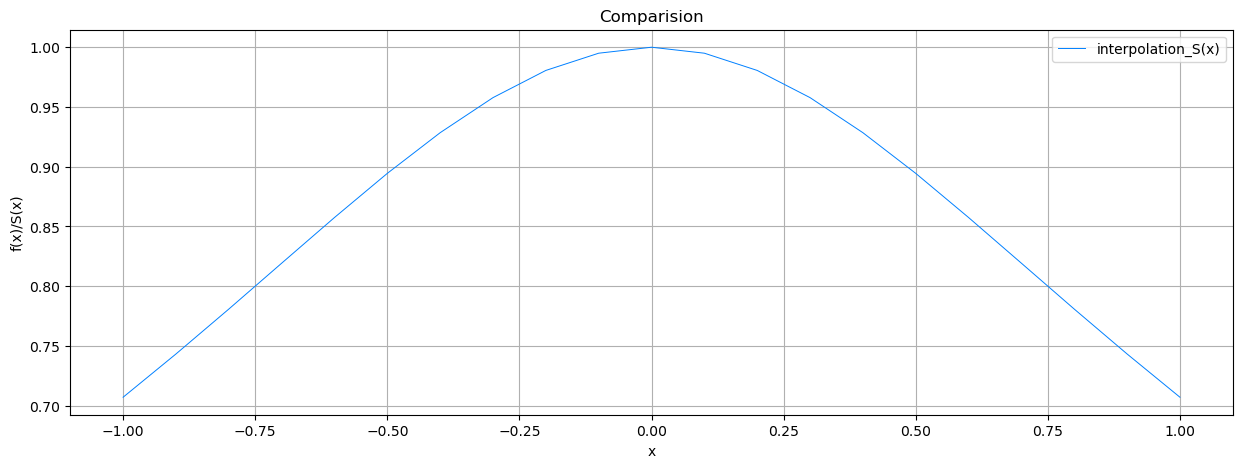

In [67]:
x_min, x_max = -1, 1
N = 11
f = lambda x: 1/(1 + x**2)**0.5

from sympy.abc import x
df = sp.diff(f(x))
dS = [df.subs(x, x_min), df.subs(x, x_max)]
x = np.linspace(x_min, x_max, N)
y = f(x)
g = CubicSpline(x, y, dS)

# 绘制函数图形
xs = np.linspace(-5, 5, 101)
plt.figure(figsize = (15, 5))
plt.plot(xs, g(xs), label = 'interpolation_S(x)', linewidth = 0.7, color = (0.0, 0.5, 1.0))
plt.xlabel('x')
plt.ylabel('f(x)/S(x)')
plt.title('Comparision')
plt.legend()
plt.grid(True)
plt.show()


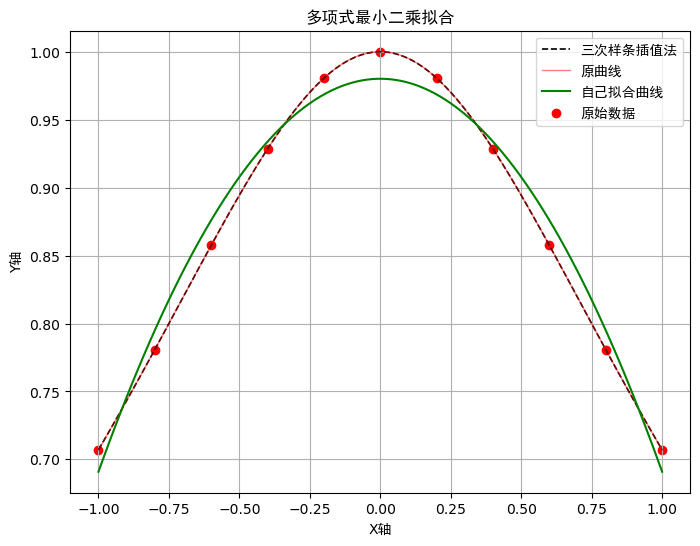

拟合的多项式系数: [ 2.13842203e-15 -2.89147131e-01 -1.77370509e-15  9.80118110e-01]


In [127]:
x_data = np.array(X, dtype=np.float32)
y_data = np.array(Y, dtype=np.float32)

# 多项式拟合的阶数
n = 3

# 使用polyfit进行多项式拟合
coefficients = np.polyfit(x_data, y_data, n)

# 构建拟合的多项式函数
fit_function = np.poly1d(coefficients)

# 在一组新的x值上计算拟合的y值
x_fit = np.linspace(-1, 1, 100)
y_fit = fit_function(x_fit)

# 使用三次样条插值法进行插值
x_min, x_max = -1, 1
N = 11
f = lambda x: 1/(1 + x**2)**0.5

from sympy.abc import x
df = sp.diff(f(x))
dS = [df.subs(x, x_min), df.subs(x, x_max)]
x3bar = np.linspace(x_min, x_max, N)
y3bar = f(x3bar)
g = CubicSpline(x3bar, y3bar, dS)

# 绘制原始数据和拟合曲线
plt.figure(figsize=(8, 6))
plt.plot(x_fit, g(x_fit), label = '三次样条插值法',linewidth = 1.2, linestyle = '--', color = 'black', alpha = 1)
plt.plot(x_fit, 1 / (1 + x_fit**2)**0.5, label='原曲线', linewidth = 1, color='r', alpha = 0.5)
# plt.plot(x_fit, y_fit, label='库拟合曲线', color='r')
plt.plot(x_fit, [PolyFit.subs(x, x_value) for x_value in x_fit], label='自己拟合曲线', color='g')
plt.scatter(x_data, y_data, label='原始数据', alpha = 1, color = 'r')
plt.legend()
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.title('多项式最小二乘拟合')
plt.grid(True)
plt.show()

# 打印拟合的多项式系数
print("拟合的多项式系数:", coefficients)


False